# Part 3: Neural Networks & Text Mining
**Person 3 - Anushka**

Deliverables from this notebook: a word cloud, a NN vs tree accuracy comparison, and a training vs validation loss curve

The goal of this section is to explore a flexible non-linear classifier (neural network) and extract qualitative context from categorical data via a simple text-mining visualization.


### Data loading and prep

In [12]:
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from wordcloud import WordCloud

# Scikit-Learn Imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import (
    LinearRegression, 
    Lasso, LassoCV,
    Ridge, RidgeCV,
)
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, log_loss, accuracy_score, classification_report, confusion_matrix

# Configuration
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('data/student-por.csv')

print(f"Sample size: {df.shape[0]} students, {df.shape[1]} variables")
print(f"\nVariable types:\n{df.dtypes.value_counts().to_string()}")

missing = df.isnull().sum()
print(f"\nMissing values: {'None' if missing.sum() == 0 else missing[missing > 0]}")

df.head()

Sample size: 649 students, 33 variables

Variable types:
object    17
int64     16

Missing values: None


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Part 1. Text Mining & Word Cloud Analysis
To capture the qualitative context of the student population, we aggregated multiple categorical variables - including parental jobs (Mjob, Fjob), reasons for school choice (reason), guardianship (guardian), and selected support/activity indicators (for example, schoolsup and activities when present) - into a single tokenized text corpus. Each observation contributes tokens of the form column_value (ex: reason_course, guardian_mother), and we then generated a Word Cloud from this aggregated token list to visualize the most frequent labels.

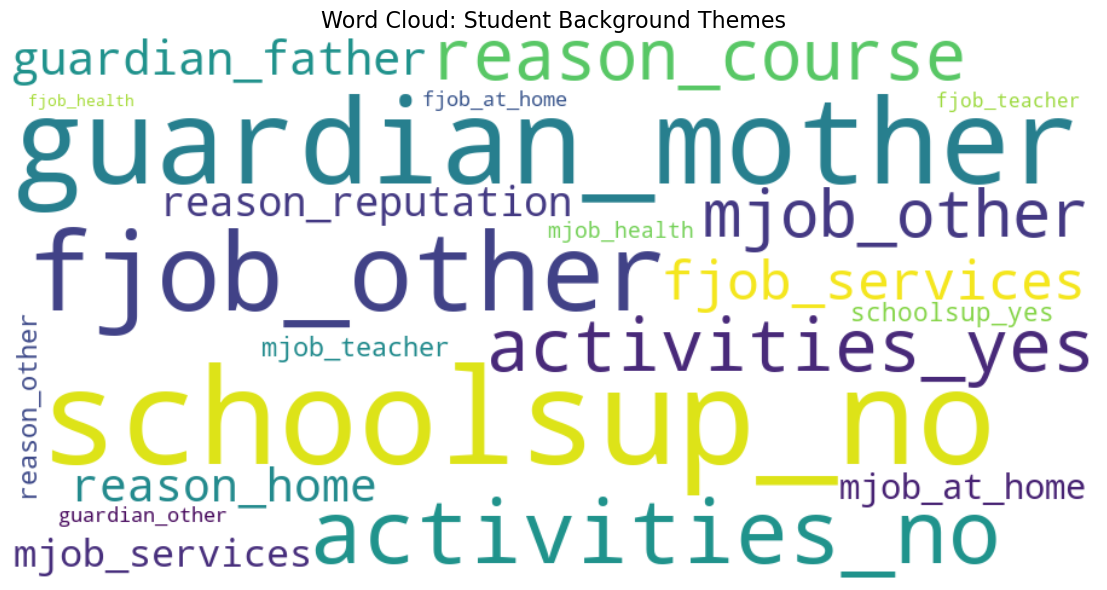

In [14]:
# verify columns exist in the dataframe to avoid errors
possible_cols = ['Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'activities']
text_cols = [c for c in possible_cols if c in df.columns]
if len(text_cols) == 0:
    raise ValueError("No valid text columns found in the dataframe.")

# We convert to string first to ensure no errors with non-text data
text_data = " ".join(
    df[text_cols]
    .fillna("")
    .astype(str)
    .apply(lambda row: " ".join([f"{col}_{row[col]}" for col in text_cols]), axis=1)
    .tolist()
).lower()

# Generate  Word Cloud
wordcloud = WordCloud(
    width=900,
    height=450,
    background_color="white",
    colormap="viridis",
    collocations=False,
    max_words=100
).generate(text_data)

# plot and save graphs
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Student Background Themes", fontsize=16)
plt.tight_layout()
plt.savefig("graphs/word_cloud.png", bbox_inches="tight", dpi=200)
plt.show()

## Part 2: Neural Network vs. Decision Tree (Classification)

We formulated a binary classification task to predict student success, defining the target variable passed as 1 if the final grade (G3) is 10 or higher and 0 otherwise. To prevent data leakage, we excluded the intermediate grades (G1 and G2) from the feature set, since they directly encode prior academic performance and would inflate predictive performance. Prior to modeling, numeric features were standardized and categorical features were one-hot encoded to support neural network convergence and ensure a fair comparison across models.

We compare a Multi-Layer Perceptron (MLP) classifier - a feedforward neural network with two hidden layers (64 and 32 units), ReLU activation, and early stopping - against a baseline decision tree capped at a maximum depth of 5. The depth-limited tree provides an interpretable benchmark, while the MLP tests whether non-linear structure and feature interactions improve pass/fail prediction.

In [15]:
# Create Binary Target (Pass = G3 >= 10)
df['passed'] = (df['G3'] >= 10).astype(int)

# fdefine x and y and drop unnecessary columns
drop_cols = ['G3', 'passed', 'G1', 'G2']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['passed']

# define Preprocessing Pipeline
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]) 

# stratified Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# apply Transformations
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# train Neural Network 
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), 
                         activation='relu', 
                         max_iter=1000, 
                         random_state=42, 
                         early_stopping=True)
nn_model.fit(X_train_scaled, y_train)

# train Decision Tree 
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# evaluate and compare

nn_pred = nn_model.predict(X_test_scaled)
dt_pred = dt_model.predict(X_test_scaled)

nn_acc = accuracy_score(y_test, nn_pred)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"Neural Network Accuracy: {nn_acc:.4f}")
print(f"Decision Tree Accuracy:  {dt_acc:.4f}")

Neural Network Accuracy: 0.8462
Decision Tree Accuracy:  0.7538


## Part 3: Training Dynamics and Loss Curve

To monitor the stability of the neural network and detect potential overfitting, we tracked log loss across 60 training epochs using a held-out validation split carved from the training data. Because accuracy alone can obscure training dynamics, log loss provides a more sensitive view of whether predicted probabilities are improving in a calibrated way over time.

The gap between the curves is crucial - if training loss continues to decrease while validation loss plateaus or increases, that pattern is consistent with overfitting. If both losses decrease together and remain close, it suggests the model is learning patterns that transfer beyond the training data.

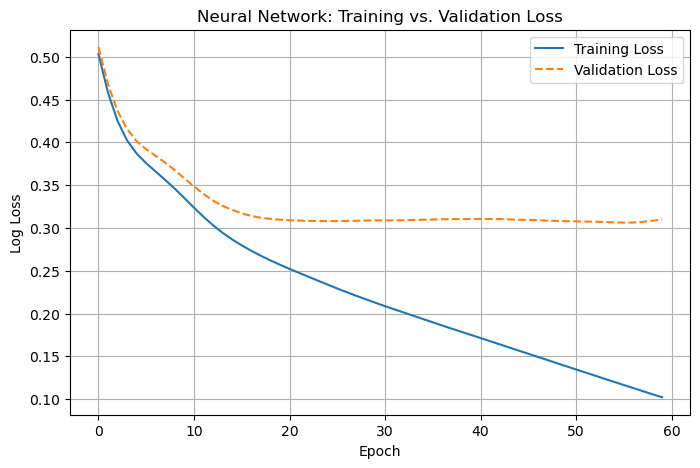

In [16]:
# Split train into train/validation to keep test clean
X_tr_scaled, X_val_scaled, y_tr, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Neural Network with Loss Tracking
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=1,
    warm_start=True,
    random_state=42
)

# Training Loop
train_losses, val_losses = [], []
epochs = 60
classes = np.unique(y_tr)

for e in range(epochs):
    mlp.partial_fit(X_tr_scaled, y_tr, classes=classes)

    p_train = mlp.predict_proba(X_tr_scaled)
    p_val   = mlp.predict_proba(X_val_scaled)

    train_losses.append(log_loss(y_tr, p_train))
    val_losses.append(log_loss(y_val, p_val))

# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Neural Network: Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("graphs/nn_loss_curve.png", bbox_inches="tight")
plt.show()


## 4. Discussion and Findings (to be made into proper report)

### Qualitative insights from text mining

The word cloud is dominated by tokens related to school choice (for example, `reason_course` and `reason_reputation`), family structure and guardianship (for example, `guardian_mother`), and common parental job categories (for example, `Mjob_services`, `Fjob_teacher`). This reflects the fact that a relatively small set of coded background levels appears repeatedly in the selected columns. Because the corpus is constructed from `column_value` tokens, these results should be interpreted as **most frequent categorical levels** rather than deeper natural-language themes. Still, the visualization provides a useful descriptive snapshot of prevalent student background attributes in this dataset.

### Model performance and value

On the held-out test set, the neural network achieved an accuracy of **0.8462**, outperforming the depth-limited decision tree baseline (**0.7538**), an absolute improvement of about **+0.09**. This gap suggests that non-linear combinations of predictors may be informative for pass/fail prediction. However, the loss curve provides an important caveat: validation loss flattened after the early epochs while training loss continued to decrease, which is consistent with diminishing returns and increasing overfitting risk as the model continues to fit the training set more closely.

### Conclusion

Overall, the neural network captures structure that a shallow decision tree misses in this split, but the added complexity must be weighed against interpretability and robustness. In this dataset ($n = 649$), neural networks can be sensitive to tuning choices and may overfit without careful regularization and validation. In educational settings where transparency matters, interpretable approaches such as decision trees or logistic regression remain attractive alternatives, offering clearer diagnostics and stakeholder-friendly reasoning while often remaining competitive in performance.

